*- Xia<br>
© copyright information:<br>
Notebook for: Entwerfen für energieeffiziente Architektur - Simulation und KI in Leibniz Universität Hannover<br>
MIT license*

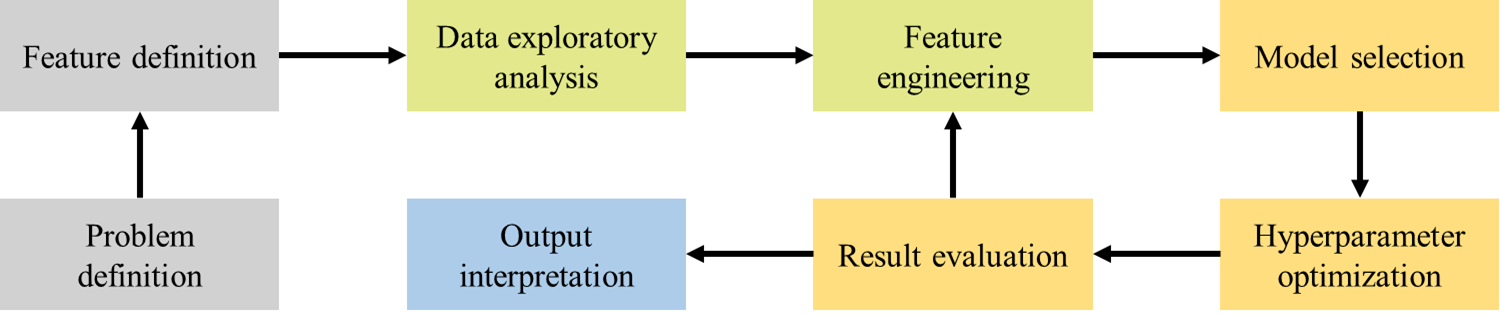

## Task 
**Based on *building features (geometry, material, energy system type)* to predict the building *energy usage density (EUI)* and *Baseboard Capacity Sum*.**

Case building:
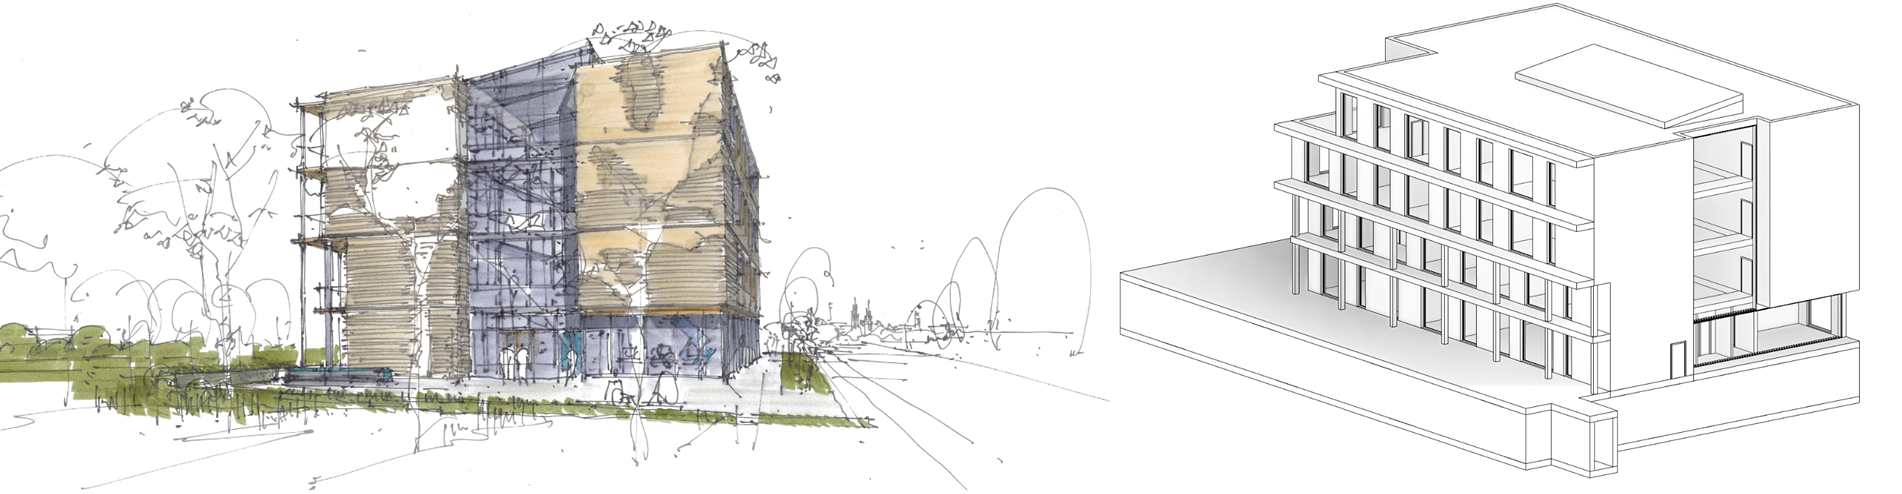

## Import packages

- sklearn: https://scikit-learn.org/stable/

In [1]:
### Here you import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Here you import machine learning models
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

### Here you import necessary tools for preprocessing data and training process
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler

### Just use for removing warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

Some metrics for evaluating performance(accuracy) of regression models
- [Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [2]:
# Result & Evaluation
### Root Mean Square Error
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Normalized Root Mean Square Error
def NRMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())/(np.max(targets)-np.min(targets))*100

### Symmetric Mean Absolute Percentage Error
def SMAPE(F, A):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

### Mean Absolute Error
def MAE(F, A):
    return 1/len(A) * np.sum(np.abs(F - A))

### Mean Square Error
def MSE(F, A):
    return 1/len(A) * np.sum(pow(np.abs(F - A),2))


def Print_result(NAME, y_pred, y_test):
    
    print('{} Result RMSE is {}, NRMSE is {}, SMAPE is {}, MAE is {}, MSE is {}, R^2 is {}'.format(NAME,
                                                                                         '%.4f' % RMSE(y_pred, y_test),
                                                                                         '%.4f' % NRMSE(y_pred, y_test),
                                                                                         '%.4f' % SMAPE(y_pred, y_test), 
                                                                                         '%.4f' % MAE(y_pred, y_test),
                                                                                         '%.4f' % MSE(y_pred, y_test),
                                                                                         '%.4f' % metrics.r2_score(y_test,y_pred)))

## Read your data

In [3]:
Training_CSV = 'Results.csv'
Case_CSV = 'BuildingLab_feature.csv'

df = pd.read_csv(Training_CSV)
df_variant = pd.read_csv(Case_CSV)

In [4]:
df.head()

,Simulation,Terrain,Orientation,NumberOfFloors,FloorHeight,Fassade,RasterLength-X,RasterLength-Y,Arm-Latitudinal-NumberOfSegments,Arm-Longitudinal-NumberOfSegments,...,EUI Natrual Gas [kWh/m?a],EUI District Heating [kWh/m?a],EUI District Cooling [kWh/m?a],Boiler Design Size Nominal Capacity [kW],CentralAirSourceHeatPumpCapacity[kW],District Heating Peak [kW],Baseboard Capacity Average [kW],Baseboard Capacity Sum [kW],Service Hot Water Tank Volume [m],Service Hot Water Design Flow Rate [l/min]
0,Simulation000,Suburbs,177,6,3.88,Vertical-Windows,3.72,3.04,5,5,...,0.000000,0.000000,0,0.00000,1919.816226,0.00000,71.130793,4196.716805,0,0.00
1,Simulation001,Urban,96,6,3.74,Vertical-Windows,2.63,2.17,4,4,...,140.123873,0.000000,0,1167.94684,0.000000,0.00000,26.115689,1540.825677,0,0.00
2,Simulation003,Country,66,1,3.14,Vertical-Windows,3.81,3.46,4,3,...,0.000000,120.320541,0,0.00000,0.000000,512.79668,59.531831,833.445631,460,7.68
3,Simulation004,Suburbs,22,8,4.23,Horizontal-Windows,3.52,2.45,3,4,...,131.697657,0.000000,0,1916.94007,0.000000,0.00000,33.405144,2572.196060,0,0.00
4,Simulation007,Suburbs,72,6,2.88,Horizontal-Windows,3.97,3.86,4,3,...,0.000000,0.000000,0,0.00000,1513.244078,0.00000,55.579362,3279.182376,420,6.90


## Prepare your inputs/output(s)

In [5]:
### Define your inputs/output(s)
input_cols = [
            'EnergyStandard',
            'HVAC-System',
            'Open Office: Heating Setpoint',
            'Open Office: ACH',
            'Open Office: PPA',
            'Volume [m³]',
            'Area [m²]',
            'Construction Area [%]',
            'Window to Wall Ratio North [%]',
            'Window to Wall Ratio East [%]',
            'Window to Wall Ratio South [%]',
            'Window to Wall Ratio West [%]'
            ]


output_cols = [
            'EUI [kWh/m²a]',
            'Baseboard Capacity Sum [kW]'
            ]

## Data preprocessing

In [6]:
# Check the types of your data inputs
df[input_cols].dtypes

EnergyStandard                     object
HVAC-System                        object
Open Office: Heating Setpoint     float64
Open Office: ACH                  float64
Open Office: PPA                  float64
Volume [m³]                       float64
Area [m²]                         float64
Construction Area [%]             float64
Window to Wall Ratio North [%]    float64
Window to Wall Ratio East [%]     float64
Window to Wall Ratio South [%]    float64
Window to Wall Ratio West [%]     float64
dtype: object

In [7]:
# Label encoding, or you can use sklearn LabelEncoder
for cat_col in ['EnergyStandard', 'HVAC-System']:
    print(dict( zip( df[cat_col].astype('category').cat.codes, df[cat_col] ) ))
    df[cat_col] = df[cat_col].astype('category').cat.codes
df_preprocessed = df[input_cols]
df_preprocessed

{1: 'NZEB', 2: 'Passive', 0: 'GEG'}
{0: 'ASHPBaseboard', 1: 'BoilerBaseboard', 2: 'DHWBaseboard'}


,EnergyStandard,HVAC-System,Open Office: Heating Setpoint,Open Office: ACH,Open Office: PPA,Volume [m³],Area [m²],Construction Area [%],Window to Wall Ratio North [%],Window to Wall Ratio East [%],Window to Wall Ratio South [%],Window to Wall Ratio West [%]
0,1,0,21.2,4.2,0.18,73842.52854,19031.579520,3.967961,27.99,21.03,27.99,21.03
1,1,1,22.8,4.9,0.19,34444.98746,9209.889696,5.519066,17.04,23.77,17.04,23.77
2,1,2,21.2,5.5,0.17,15443.03624,4918.164408,5.123310,15.29,24.16,15.29,24.16
3,1,1,23.1,5.1,0.07,61433.33566,14523.247200,4.654997,42.92,26.25,42.92,26.25
4,2,0,21.5,4.9,0.06,52674.44885,18289.739180,4.419944,27.40,32.71,27.40,32.71
...,...,...,...,...,...,...,...,...,...,...,...,...
913,2,0,21.3,4.8,0.13,37593.22406,10559.894400,6.331114,40.89,30.28,40.89,27.53
914,1,0,23.1,5.7,0.13,29221.51913,7416.629220,5.593305,18.19,24.40,18.19,24.40
915,2,0,23.6,5.5,0.07,30592.81244,8093.336625,6.204768,26.14,13.80,26.14,13.80
916,1,1,23.4,4.2,0.17,25759.46355,8390.704740,5.737872,15.49,20.42,15.49,20.42


**You need to know** --> (L03, L05)
- [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler): If we use non-tree-based model, don't forget to standarize the data.
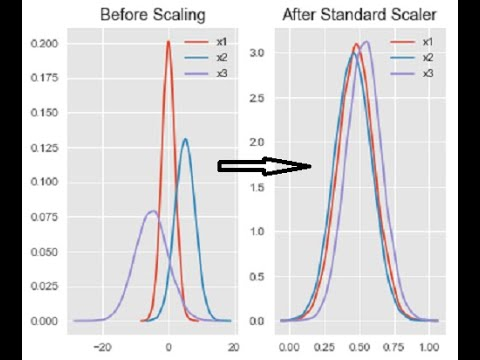
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV): To find the best hyper-parameters of the model.
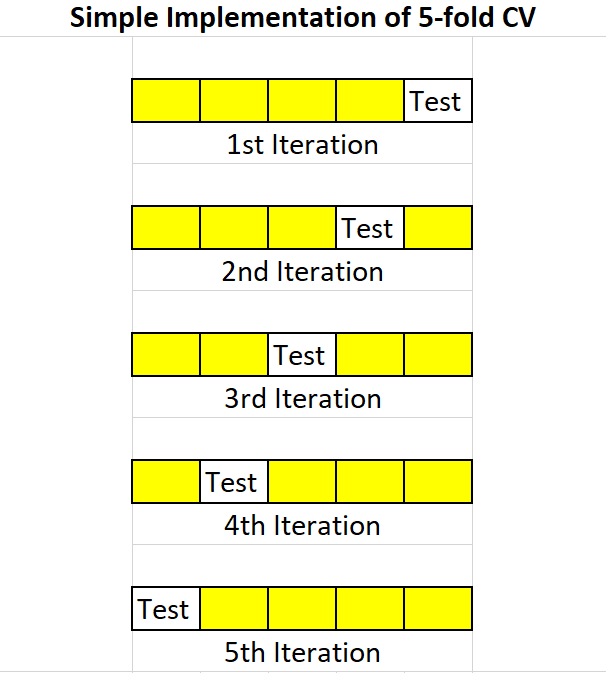
- [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR): Support Vector Machine, Regression
- [DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor): Tree-based Model
- [NeuralNetwork](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor): Neural Network

## Model training and evaluation

In [8]:
### Start modeling & evaluating performance
for output in output_cols:
    print('The output is:', output)
    
    ### Set your output
    y = df[output]
    
    ### Split the data into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(df_preprocessed, y, test_size=0.2, random_state=42)
    
    ### Standardize your data
    scaler = StandardScaler()  
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    ################################################# Now is for DecisionTree ###################################################
    ### Model define, train, and predict
    regr = DecisionTreeRegressor()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    
    ### Check result
    Print_result('Decision Tree', y_pred, y_test)
    
    ### Test on the case data
    df_target_input = df_variant[input_cols]
    y_preds_t = regr.predict(scaler.transform(df_target_input))
    print(y_preds_t)
    print('*'*25)
    
    
    #################################################### Now is for SVR #######################################################
    ### Set model's hyperparameter space
    parameters=[
                {'C': [1,10,100,1000],
                 'kernel':['rbf','linear'],
                 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
               ]
    
    ### Model define, search the best performance in the dataset
    regr=SVR()
    grid_search=GridSearchCV(estimator=regr,
                         param_grid=parameters,
                         cv=5,
                         n_jobs=-1)
    grid_search=grid_search.fit(X_train,y_train)
    
    ### Best model define, train, and predict
    regr = SVR(
                    kernel=grid_search.best_params_['kernel'], 
                    C=grid_search.best_params_['C'], 
                    gamma = grid_search.best_params_['gamma']
                    )
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    
    ### Check result
    Print_result('SVR', y_pred, y_test)
    
    ### Test on the case data  
    df_target_input = df_variant[input_cols]
    y_preds_t = regr.predict(scaler.transform(df_target_input))
    print(y_preds_t)
    print('*'*25)
    
    
    #################################################### Now is for ANN #######################################################
    ### Set model's hyperparameter space
    parameters = {
                  "hidden_layer_sizes": [(1,),(50,)], 
                  "activation": ["identity", "logistic", "tanh", "relu"], 
                  "solver": [ "sgd", "adam"], 
                  "alpha": [0.00005,0.0005]
                }
    
    ### Model define, search the best performance in the dataset
    regr=MLPRegressor()
    grid_search=GridSearchCV(estimator=regr,
                         param_grid=parameters,
                         cv=5,
                         n_jobs=-1)
    grid_search=grid_search.fit(X_train,y_train)
    
    ### Best model define, train, and predict
    regr = MLPRegressor(
                        hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'], 
                        activation=grid_search.best_params_['activation'], 
                        solver = grid_search.best_params_['solver'], 
                        alpha = grid_search.best_params_['alpha']
                        )
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    ### Check result
    Print_result('ANN', y_pred, y_test)
    
    ### Test on the case data
    df_target_input = df_variant[input_cols]
    y_preds_t = regr.predict(scaler.transform(df_target_input))
    print(y_preds_t)
    print('*'*25)

The output is: EUI [kWh/m²a]
Decision Tree Result RMSE is 24.9803, NRMSE is 8.5868, SMAPE is 12.3286, MAE is 17.7635, MSE is 624.0156, R^2 is 0.7739
[108.053 108.053  95.449 237.071 191.772 191.772 190.487 139.967 139.967]
*************************
SVR Result RMSE is 15.2138, NRMSE is 5.2296, SMAPE is 8.0038, MAE is 10.5573, MSE is 231.4598, R^2 is 0.9161
[105.58401903 107.78857074 112.57466193 188.58276494 184.11298234
 171.97066076 169.57553897 153.92899598 144.37936892]
*************************
ANN Result RMSE is 13.0230, NRMSE is 4.4766, SMAPE is 5.7488, MAE is 7.7936, MSE is 169.5982, R^2 is 0.9386
[109.96479574 104.83028444 100.55846075 217.49963167 204.64687737
 191.34135978 186.75106292 178.48950476 169.48416563]
*************************
The output is: Baseboard Capacity Sum [kW]
Decision Tree Result RMSE is 328.2793, NRMSE is 3.9298, SMAPE is 9.6790, MAE is 210.3640, MSE is 107767.2998, R^2 is 0.9392
[874.771486 874.771486 874.771486 413.803229 413.803229 413.803229
 413.803